In [2]:
using Pkg
Pkg.add("StaticArrays")
Pkg.add("LinearAlgebra")
Pkg.add("Combinatorics")
Pkg.add("Ripserer")
Pkg.add("Plots")
Pkg.add("Random")
Pkg.add("MultivariateStats")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Ch

In [3]:
using StaticArrays
using LinearAlgebra
using Combinatorics
using Ripserer
using Plots
using Random
using MultivariateStats

sa = StaticArrays
la = LinearAlgebra
cm = Combinatorics 

Combinatorics

In [4]:
SPoint = sa.SVector{2, Float64}
SamePoints = Tuple{SPoint, SPoint, SPoint, SPoint}
function first_in_klein(point::SPoint)::SPoint
    x::Float64 = point[1]
    y::Float64 = point[2]
    if (0 <= x <= 1) & (0 <= y <= 1)
        return point

    elseif -1 <= x < 0 < y <= 1
        return @sa.SVector [x + 2.0, 2.0 - y]

    elseif (-1 <= x < 0) & (-1 <= y <= 0)
        return @sa.SVector [x + 2.0, -y]

    elseif (-1 <= y < 0 <= x <=1)
        return @sa.SVector [x, 2.0 + y]
    end
    throw(DomainError(point, "Make sure that the first and second coordinates are in the intreval [-1, 1]"))
end

function samepoints_in_kelin(point:: SPoint)::SamePoints
    firstpoint:: SPoint = first_in_klein(point)
    x:: Float64 = firstpoint[1]
    y:: Float64 = firstpoint[2]
    second:: SPoint = @sa.SVector [x - 2.0, 2.0 - y]
    theard:: SPoint = @sa.SVector [x - 2.0, -y]
    fourth:: SPoint =  @sa.SVector [x, y - 2.0]
    return (firstpoint, second, theard, fourth)
end


samepoints_in_kelin (generic function with 1 method)

In [5]:
point = @sa.SVector [0.5, -1.0]
println(samepoints_in_kelin(point))

([0.5, 1.0], [-1.5, 1.0], [-1.5, -1.0], [0.5, -1.0])


In [6]:
Quadrants = Tuple{Int64, Int64}

function quadrants_square_distance(quadrants:: Quadrants, samepoints1:: SamePoints, samepoints2:: SamePoints)::Float64
    index1:: Int64 = quadrants[1]
    index2:: Int64 = quadrants[2]
    diff:: SPoint = samepoints1[index1]- samepoints2[index2]
    return la.norm(diff)
end

function candidates_quadrants(point1:: SPoint, point2:: SPoint)::Tuple{Quadrants, Quadrants}
    add_second:: Float64 = (point1 + point2)[2]
    diff:: SPoint = point1 - point2
    #print(diff[2], 'in candidate_quadrants')
    #candidate1:: Quadrants = (1, 3) if (add_second < 1.0)  else (1, 2) if (add_second < 3.0) else (4, 2)
    candidate1:: Quadrants = add_second < 1.0 ? (1, 3) : add_second < 3.0 ? (1, 2) : (4, 2)
    candidate2:: Quadrants =  diff[2] < -1.0 ? (1, 4) : diff[2] < 1.0 ? (1, 1) : (2, 3)
    return (diff[1] >= 0 ? reverse(candidate1) : candidate1, candidate2)
end


candidates_quadrants (generic function with 1 method)

In [20]:

function distance_in_klein_bottle(point1:: SPoint, point2:: SPoint)::Float64
    samepoints1:: SamePoints = samepoints_in_kelin(point1)
    samepoints2:: SamePoints = samepoints_in_kelin(point2)
    if samepoints1 === samepoints2
        return 0.0
    end
    point1_in_first:: SPoint = samepoints1[1]
    point2_in_first:: SPoint = samepoints2[1]
    candidates:: Tuple{Quadrants, Quadrants} = candidates_quadrants(point1_in_first, point2_in_first)
    #print(candidates, 'in dist klein')
    dist1:: Float64 = quadrants_square_distance(candidates[1], samepoints1, samepoints2)
    dist2:: Float64 = quadrants_square_distance(candidates[2], samepoints1, samepoints2)
    #print(dist1, dist2)
    distance:: Float64 = minimum((dist1, dist2))
end

function matrix_index(;matrix_size::Tuple{Int64, Int64}, index::Int64):: Tuple{Int64, Int64}
    row:: Int64 = matrix_size[1]
    column:: Int64 = matrix_size[2]
    remainder:: Int64 = rem(index, row)
    division:: Int64 = div(index, row)
    if index > row * column
        throw(DomainError(index, "Make sure that index <= row * column"))
    end

    return remainder !== 0 ? (remainder, division + 1) : (row, division)
    
end

function matrix_index(indexies:: Tuple{Int64, Int64};matrix_size::Tuple{Int64, Int64}):: Int64
    i:: Int64, j:: Int64 = indexies
    row:: Int64, column:: Int64 = matrix_size
    index:: Int64 = (j - 1) * row + i
    if (i > row) || (j > column)
        throw(DomainError(index, "Make sure that each index <= row , column"))
    end
    return index
end

function distance_matrix(pointcloud:: Vector{SPoint}):: Array{Float64, 2}
    point_num:: Int64 = size(pointcloud, 1)
    indexcombs::Base.Generator{Combinatorics.Combinations,Combinatorics.var"#10#13"{Combinatorics.var"#reorder#11"{UnitRange{Int64}}}} = cm.combinations(1:point_num, 2)
    dist_matrix:: Array{Float64, 2} = zeros(point_num, point_num)
    for indexies = indexcombs
        i::Int64, j:: Int64 = reverse(Tuple(indexies))
        dist_matrix[matrix_index((i, j), matrix_size=(point_num, point_num))] = distance_in_klein_bottle(pointcloud[i], pointcloud[j])
    end
    #return map(points:: Vector{SPoint}-> distance_in_klein_bottle(points[1], points[2])::Float64, combs)
    return dist_matrix + transpose(dist_matrix)
end



distance_matrix (generic function with 1 method)

In [8]:
index = matrix_index((2, 1), matrix_size=(5, 5))
println(index)
matrix_index(matrix_size=(5, 5), index=index)

2


(2, 1)

In [9]:
point1 = @sa.SVector [1.0, 0.3]
point2 = @sa.SVector [-1.0, -0.3]
println(distance_in_klein_bottle(point1, point2))

0.0


In [17]:
function uniformpoints_in_square(;range_min:: Float64, range_max:: Float64, sampling:: Int64, step:: Float64 = 0.00001)::Array{Float64,}
    rng = range_min:step:range_max
    dim:: Int64 = 2
    return rand(rng, (sampling, dim))
end


function staticalize(ndarray:: Array{Float64, 2})::Vector{SPoint}
    rownum ::Int = size(ndarray, 1)
    return [SPoint(ndarray[i,:]) for i = 1:rownum]
end

staticalize (generic function with 1 method)

In [49]:
pointcloud = uniformpoints_in_square(range_min=-1.0, range_max=1.0, sampling=500)
staticpointcloud = staticalize(pointcloud)


500-element Vector{SVector{2, Float64}}:
 [0.02632, 0.15717]
 [0.57319, -0.35661]
 [-0.78323, 0.13566]
 [-0.66848, 0.84956]
 [-0.82654, -0.68216]
 [-0.98226, 0.02447]
 [0.6633, 0.63651]
 [-0.51369, -0.09965]
 [0.78142, -0.53192]
 [0.67701, 0.03144]
 [-0.5086, 0.05426]
 [0.69245, 0.03654]
 [-0.98607, -0.55637]
 ⋮
 [0.85464, 0.95465]
 [-0.0808, 0.00816]
 [0.1554, 0.57117]
 [0.52044, 0.20814]
 [-0.42914, -0.51413]
 [-0.02297, 0.62581]
 [0.21529, 0.49103]
 [0.47168, -0.19361]
 [0.30353, -0.4118]
 [0.82143, 0.9152]
 [0.46347, -0.08759]
 [0.12031, 0.1703]

In [50]:
distmat = distance_matrix(staticpointcloud)

500×500 Matrix{Float64}:
 0.0        0.750358  0.809836  0.980893  …  1.09855    0.501007  0.0949027
 0.750358   0.0       0.680451  0.904469     0.76934    0.290534  0.694791
 0.809836   0.680451  0.0       0.723063     1.02818    0.754832  0.904204
 0.980893   0.904469  0.723063  0.0          0.56172    1.15504   1.04095
 1.1966     1.13326   0.818966  0.494236     0.422176   1.04719   1.17095
 1.00792    0.554925  0.227983  0.882741  …  0.959957   0.557852  0.918322
 0.797189   0.9972    0.95004   0.842996     0.320427   0.751168  0.715674
 0.597969   1.02077   0.357802  0.961748     1.05223    0.977234  0.689078
 1.02226    0.272201  0.588686  0.635221     0.554326   0.546371  0.964458
 0.662726   0.401698  0.565034  1.09752      0.895482   0.244474  0.573757
 0.544729   0.966708  0.28644   0.811211  …  1.17844    0.982365  0.639526
 0.676964   0.41084   0.551873  1.09251      0.888076   0.260461  0.587568
 1.06524    1.0138    0.721145  0.673634     0.407204   0.847166  0.973451
 

In [51]:
klein_vrip_fill = Rips(distmat; threshold=nothing)
klein_vrips_co = ripserer(klein_vrip_fill; dim_max=2, reps=true)


3-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 138-element 1-dimensional PersistenceDiagram
 100-element 2-dimensional PersistenceDiagram

In [52]:
vrips = ripserer(staticpointcloud;  dim_max=2)

3-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 115-element 1-dimensional PersistenceDiagram
 2-element 2-dimensional PersistenceDiagram

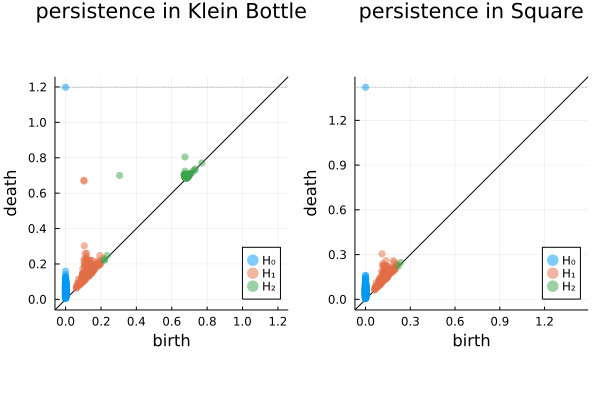

In [53]:
plot(plot(klein_vrips_co; title="persistence in Klein Bottle"), plot(vrips; title="persistence in Square"))

In [54]:
function plotting_cycle(;pointcloud, cohomology, legend=nothing)
    filtration = cohomology[2].filtration
    most_persistent_co = cohomology[2][end]
    reconstructed_at_birth_most = reconstruct_cycle(filtration, most_persistent_co)
    second_persistent_co = cohomology[2][end - 1]
    reconstructed_at_birth_second = reconstruct_cycle(filtration, second_persistent_co)
    common_cycle = intersect(reconstructed_at_birth_most, reconstructed_at_birth_second)
    num_point = size(pointcloud, 1)
    x = pointcloud[1:num_point]
    y = pointcloud[num_point + 1:end]
    scatter(x,y; label="data", markersize=2, legend = legend)
    plot!(reconstructed_at_birth_most, x, y; label="most_persistent", color="blue")
    plot!(reconstructed_at_birth_second, x, y; label="second_persistent", color="red")
    if !isempty(common_cycle)
        plot!(common_cycle, x, y; label="intersect", color="green")
    end
    plot!()
end

plotting_cycle (generic function with 1 method)

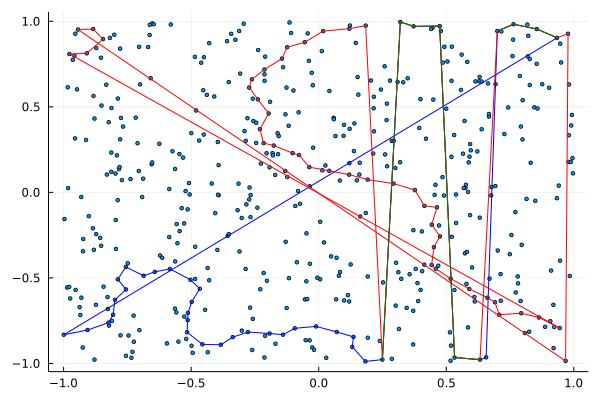

In [55]:
plotting_cycle(;pointcloud=pointcloud, cohomology=klein_vrips_co, legend=nothing)

In [56]:
function randn_poitns(;num_point:: Int64, dim:: Int64=2)::Array{Float64, 2}
    rng = MersenneTwister()
    randompoints = randn(rng, (num_point, dim))
    max_range = maximum(map(point -> norm(point), randompoints))
    randompoints = randompoints / max_range
end

randn_poitns (generic function with 1 method)

In [64]:
pointcloud = randn_poitns(;num_point=500, dim=2)


500×2 Matrix{Float64}:
  0.30723     0.349691
  0.0181981  -0.461592
  0.416865    0.166671
 -0.337834    0.317338
 -0.266443    0.616485
 -0.583306    0.0381733
 -0.0585004  -0.0496307
 -0.286754   -0.206815
  0.528748   -0.046961
 -0.0109013  -0.500157
 -0.624498   -0.00984285
 -0.370347    0.0431016
  0.0789377  -0.285662
  ⋮          
 -0.0151746   0.242147
  0.0422276  -0.358951
  0.374408   -0.710977
 -0.138179    0.0183128
  0.741211   -0.00650316
 -0.290693    0.00301305
 -0.07841     0.0197477
  0.163227    0.249383
 -0.345954   -0.068991
 -0.0957769  -0.297423
 -0.232951    0.278389
  0.128632   -0.0530218

In [65]:
staticpointcloud = staticalize(pointcloud)
distmat = distance_matrix(staticpointcloud)
klein_vrips_fill = Rips(distmat; threshold=nothing)
klein_vrips_co = ripserer(klein_vrips_fill; dim_max=2, reps=true)
vrips = ripserer(staticpointcloud;  dim_max=2)

3-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 127-element 1-dimensional PersistenceDiagram
 0-element 2-dimensional PersistenceDiagram

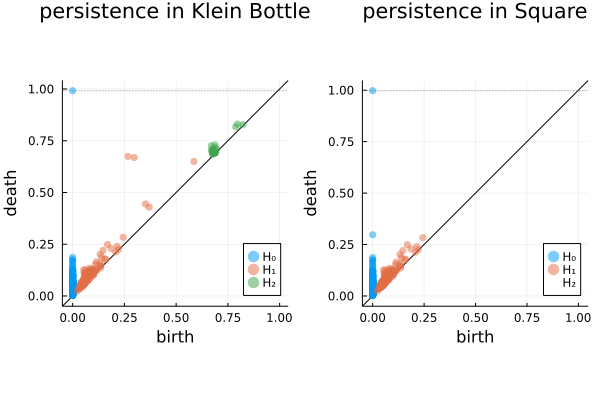

In [66]:
plot(plot(klein_vrips_co; title="persistence in Klein Bottle"), plot(vrips; title="persistence in Square"))

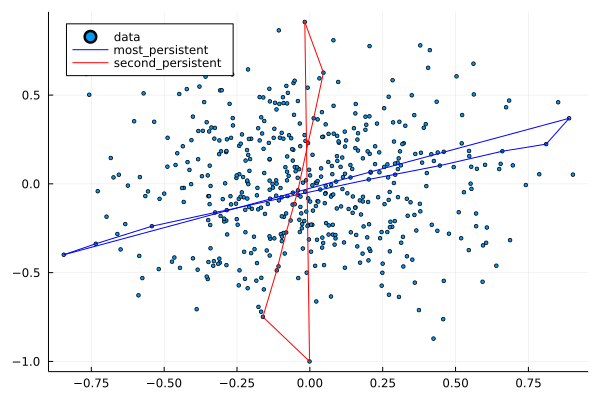

In [68]:
plotting_cycle(;pointcloud=pointcloud, cohomology=klein_vrips_co, legend=:topleft)

In [70]:
pointcloud = randn_poitns(;num_point=500, dim=10)
M = fit(PCA, transpose(pointcloud);maxoutdim=2)
x = Matrix(pointcloud)'

10×500 adjoint(::Matrix{Float64}) with eltype Float64:
  0.0882228  -0.0897729   0.0428354   0.161366    …  -0.0722853  -0.225645
 -0.313644   -0.273003   -0.248864    0.296367       -0.182095   -0.531429
 -0.376163   -0.0199066   0.356611   -0.0849673      -0.348769   -0.233982
 -1.0         0.289005    0.0383334   0.0954453      -0.0462128   0.144498
  0.0941265  -0.684817    0.120842   -0.0704244       0.35121     0.382039
  0.215969   -0.393621   -0.0517471  -0.272546    …   0.169175    0.186021
  0.357809    0.510207   -0.225901    0.0418181      -0.0143525  -0.00462912
 -0.0303428   0.323521    0.310833   -0.00448158      0.424755    0.151521
 -0.061607   -0.107521   -0.260658    0.0150785       0.322312   -0.294428
 -0.0554317   0.133903   -0.992576    0.0251453       0.425112    0.22102

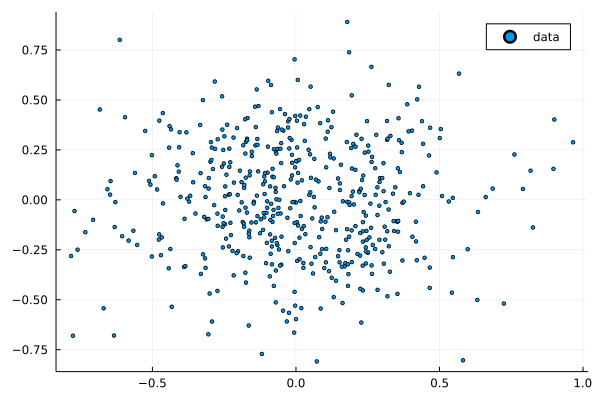

In [71]:
pointcloud_pca = transpose(predict(M, x))
num_point = size(pointcloud_pca, 1)
x = pointcloud_pca[1:num_point]
y =pointcloud_pca[num_point + 1: end]
scatter(x,y; label="data", markersize=2)


In [72]:
staticpointcloud = staticalize(Matrix(pointcloud_pca))
max_range = maximum(map(point -> norm(point), staticpointcloud))
staticpointcloud /= max_range
distmat = distance_matrix(staticpointcloud)
klein_vrips_fill = Rips(distmat; threshold=nothing)
klein_vrips_co = ripserer(klein_vrips_fill; dim_max=2, reps=true)
vrips = ripserer(staticpointcloud;  dim_max=2)

3-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 128-element 1-dimensional PersistenceDiagram
 0-element 2-dimensional PersistenceDiagram

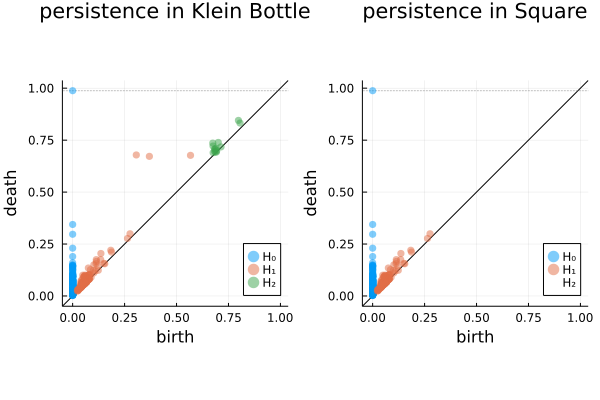

In [73]:
plot(plot(klein_vrips_co; title="persistence in Klein Bottle"), plot(vrips; title="persistence in Square"))

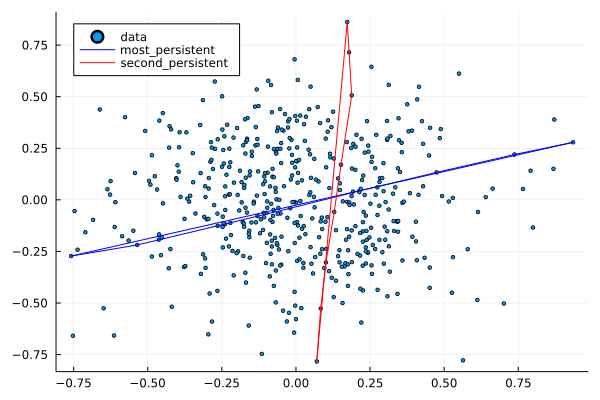

In [74]:
plotting_cycle(;pointcloud=pointcloud_pca/max_range, cohomology=klein_vrips_co, legend=:topleft)